In [1]:
from typing import Callable, Optional
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Dataset
from torch_geometric.nn import VGAE, GATConv, GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from typing import Any, List
import os
import os.path as osp
from copy import copy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle

#empty cuda cache
torch.cuda.empty_cache()


c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\thesis\Lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Defining The baseline graph autoencoder

In [2]:
class GraphEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, encoding_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x=F.dropout(x,p=0.2)
        z = self.conv2(x, edge_index)
        z=F.dropout(z,p=0.2)
        return z

# Define the graph decoder model
class GraphDecoder(torch.nn.Module):
    def __init__(self, encoding_dim, hidden_dim, output_dim):
        super(GraphDecoder, self).__init__()
        self.conv1 = GCNConv(encoding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, z, edge_index):
        x = F.relu(self.conv1(z, edge_index))
        x=F.dropout(x,p=0.2)
        x = self.conv2(x, edge_index)
        x=F.dropout(x,p=0.2)

        return x

# Importing the datasets 
 --> All datas: In graph format

In [3]:
import glob

files=glob.glob("./Seperated_dataset/*")
all_graphs=[]

for dataset_folder in files:
    graph_path=f"{dataset_folder}/train_feature.pt"
    graphs=torch.load(graph_path)
    print(len(graphs))
    all_graphs+=graphs
    
    

1900
760
606
720
1874
892
444
2196
676
856
2284
1074


In [8]:
# all_graphs_labels=[]
# files=glob.glob("./Seperated_dataset/*")

# for dataset_folder in files:
#     graph_path=f"{dataset_folder}/train_labels.pt"
#     graphs=torch.load(graph_path)
#     print(len(graphs))
#     all_graphs_labels+=graphs

In [68]:
all_graphs[0]

Data(x=[51, 20], edge_index=[2, 52], edge_attr=[52, 19])

# Creation of Dual graph

In [9]:
import torch
from torch_geometric.data import Data

def remove_bidirectional_duplicates(edge_index, edge_attr):
    # Initialize containers for unique edges and their attributes
    unique_edge_list = []
    unique_edge_attr_list = []
    
    # Create a dictionary to track seen edges and their inverse
    seen_edges = {}

    for i, edge in enumerate(edge_index.t().tolist()):
        edge_tuple = tuple(edge)
        inverse_edge_tuple = tuple(edge[::-1])

        # If the edge or its inverse hasn't been seen, add it to the unique lists
        if edge_tuple not in seen_edges and inverse_edge_tuple not in seen_edges:
            seen_edges[edge_tuple] = i  # Mark this edge as seen
            unique_edge_list.append(edge)
            unique_edge_attr_list.append(edge_attr[i])
        elif inverse_edge_tuple in seen_edges:
            # If the inverse edge was seen but this direction is needed (for genuinely bidirectional edges), keep it
            # This part depends on whether we want to strictly remove inverse duplicates
            # or allow one direction to be represented. Adjust according to our exact needs.
            pass

    # Convert the lists back to tensors
    filtered_edge_index = torch.tensor(unique_edge_list).t().contiguous()
    filtered_edge_attr = torch.stack(unique_edge_attr_list)

    return filtered_edge_index, filtered_edge_attr

def create_line_graph(data):
    # Remove bidirectional duplicates while keeping the directed nature and adjusting edge attributes accordingly
    edge_index_directed, edge_attr_directed = remove_bidirectional_duplicates(data.edge_index, data.edge_attr)
    
    # The rest of our line graph creation logic...
    num_edges = edge_index_directed.size(1)
    x_prime = edge_attr_directed  # Edge attributes of G become node features of G'

    # add one extra node feature to x_prime
    x_prime = torch.cat([x_prime, torch.randn((num_edges, 1))], dim=1)

    

    connections = []
    for i in range(num_edges):
        for j in range(i + 1, num_edges):
            if len(set(edge_index_directed[:, i].tolist()) & set(edge_index_directed[:, j].tolist())) > 0:
                connections.append([i, j])
                connections.append([j, i])  # Assuming undirected connections in G'

    edge_index_prime = torch.tensor(connections).t().contiguous()
    
    # Placeholder: Create edge attributes for G' (e.g., based on node features of G)
    # edge_attr_prime = torch.randn((edge_index_prime.size(1), data.x.size(1)))  # Example feature transformation
    
    data_prime = Data(x=x_prime, edge_index=edge_index_prime)
    
    return data_prime




In [10]:
all_graph_final=[]
all_dual_graphs=[]

for graph in tqdm(all_graphs):

    if(graph is None):
        continue
    if(graph.edge_index is None):
        continue
    if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
        continue

    all_graph_final.append(graph)
    dual_graph=create_line_graph(graph)

    all_dual_graphs.append(dual_graph)

100%|██████████| 14282/14282 [00:24<00:00, 593.85it/s]


In [11]:
len(all_graph_final),len(all_dual_graphs)

(98186, 98186)

In [36]:
all_dual_graphs[0]

Data(x=[26, 20], edge_index=[2, 78])

In [37]:
all_graph_final[0]

Data(x=[51, 20], edge_index=[2, 52], edge_attr=[52, 19])

In [38]:
all_combined_graphs = []

for graph, dual_graph in tqdm(zip(all_graph_final, all_dual_graphs), total=len(all_graph_final)):
    # Concatenate the node features
    combined_x = torch.cat([graph.x, dual_graph.x], dim=0)
    
    # Adjust the edge indices for the dual graph
    num_nodes_graph = graph.x.size(0)  # Number of nodes in the original graph
    adjusted_edge_index_dual = dual_graph.edge_index + num_nodes_graph
    
    # Concatenate the edge indices
    combined_edge_index = torch.cat([graph.edge_index, adjusted_edge_index_dual], dim=1)
    
    # Assuming edge attributes are not being combined or do not exist; if they do, similar adjustments are needed
    
    # Create a new graph instance, here using Data from torch_geometric to represent the combined graph
    combined_graph = Data(x=combined_x, edge_index=combined_edge_index)
    
    # If there are edge attributes or other graph components (e.g., edge_attr, y, etc.), ensure to handle them accordingly
    
    all_combined_graphs.append(combined_graph)


  0%|          | 0/98186 [00:00<?, ?it/s]

In [12]:
all_combined_graphs=all_dual_graphs

# Define model with dual loss

In [13]:
from tqdm.notebook import tqdm  # Import tqdm for notebook
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create instances of the graph encoder and decoder models
input_dim = 20
hidden_dim = 16
encoding_dim = 16
output_dim = input_dim
encoder = GraphEncoder(input_dim, hidden_dim, encoding_dim)
decoder = GraphDecoder(encoding_dim, hidden_dim, output_dim)

# Move the models to the GPU
encoder = encoder.to(DEVICE)
decoder = decoder.to(DEVICE)



# Define the loss function
# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = torch.nn.MSELoss()  # If the features are continuous


# TODO: Loss function may need to be changed. Not sure if BCE is the right one

# Define the optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)

# Training loop
def train():

    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    total_loss=0
    
    for graph in tqdm(all_combined_graphs):

        # move the graph to the GPU


        graph = graph.to(DEVICE)
        # dual_graph = dual_graph.to(DEVICE)

        graph.edge_index=graph.edge_index.long()

        
        # print(graph)
        if graph is None:
            continue
        if graph.edge_index.shape[0] == 0 :
            continue



        x = graph.x
        edge_index = graph.edge_index
        z = encoder(x, edge_index)
        reconstructed_x = decoder(z, edge_index)
        loss = loss_fn(reconstructed_x, x)
        total_loss += loss.item()
        loss.backward()
    optimizer.step()
    return total_loss /len(all_combined_graphs)

# Evaluation loop
def test():
    encoder.eval()
    decoder.eval()
    total_loss=0
    with torch.no_grad():
        for graph in tqdm(all_combined_graphs):


            # move the graph to the GPU


            graph = graph.to(DEVICE)
            # dual_graph = dual_graph.to(DEVICE)

            
            # print(graph)
            if graph is None:
                continue
            if graph.edge_index.shape[0] == 0 :
                continue



            x = graph.x
            edge_index = graph.edge_index
            z = encoder(x, edge_index)
            reconstructed_x = decoder(z, edge_index)
            loss = loss_fn(reconstructed_x, x)
            total_loss += loss.item()
            loss.backward()
    return total_loss / len(all_combined_graphs)

# Train and evaluate the model
for epoch in range(100):

    print(f'Epoch: {epoch}')
    loss = train()
    print(f'Loss: {loss:.4f}')
    if(epoch%10==0):
        torch.save(encoder.state_dict(), f'encoder_weights_dual_epoch_{epoch+1}.pth')
        torch.save(decoder.state_dict(), f'decoder_weights_dual_epoch_{epoch+1}.pth')


    #if epoch % 10 == 0:
    # eval_loss= test()
    # print(f'Epoch: {epoch}, Loss: {loss:.4f}, Eval Loss: {eval_loss:.4f}')

Epoch: 0


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.3494
Epoch: 1


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.2779
Epoch: 2


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.2453
Epoch: 3


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.2247
Epoch: 4


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.2119
Epoch: 5


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.2061
Epoch: 6


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.1979
Epoch: 7


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.1894
Epoch: 8


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.1834
Epoch: 9


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.1795
Epoch: 10


  0%|          | 0/14249 [00:00<?, ?it/s]

Loss: 0.1771
Epoch: 11


  0%|          | 0/14249 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Visualization

In [82]:
sampled_graphs=all_combined_graphs[:10000]
sample_labels=all_graphs_labels[:10000]  

encoded_graphs=[]

encoded_graph_labels=[]

for graph,label in tqdm(zip(sampled_graphs,sample_labels)):


    # print(graph)
    if graph is None:
        continue
    if graph.edge_index.shape[0] == 0 :
        continue

    graph = graph.to(DEVICE)
    x = graph.x
    edge_index = graph.edge_index
    z = encoder(x, edge_index)
    encoded_graphs.append(z.cpu().detach().numpy())
    encoded_graph_labels.append(label)





0it [00:00, ?it/s]

In [83]:
len(encoded_graphs)

10000

In [84]:
# mean of the encoded graphs
import numpy as np

for i in range(len(encoded_graphs)):
    encoded_graphs[i]=np.mean(encoded_graphs[i],axis=0)

In [85]:
encoded_graphs[0].shape

(16,)

In [87]:
np.array(encoded_graph_labels[:10000]).sum()/10000

0.1123

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.183407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.518158
[t-SNE] KL divergence after 1000 iterations: 2.502249


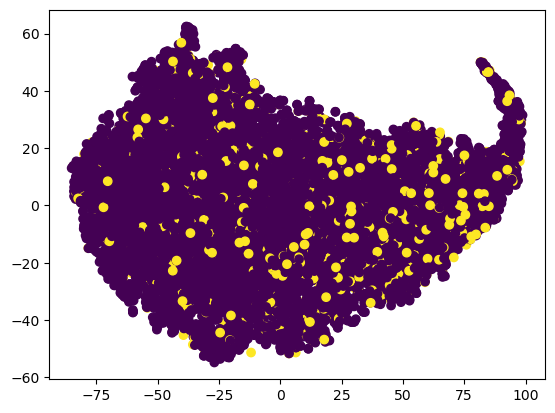

In [88]:
# perform t-sne on the encoded graphs

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

encoded_graph_array=np.zeros((len(encoded_graphs),16))  


for i in range(len(encoded_graphs)):
    encoded_graph_array[i,:]=encoded_graphs[i]

tsne = TSNE(n_components=2, random_state=42,verbose=1,perplexity=30,n_iter=1000,learning_rate=200,early_exaggeration=12,angle=0.2)

tsne_obj=tsne.fit_transform(encoded_graph_array)

tsne_obj.shape

plt.scatter(tsne_obj[:,0],tsne_obj[:,1],c=encoded_graph_labels)

plt.show()

# Training and Testing

In [14]:
nr_ahr_data=torch.load("Seperated_dataset/nr-ahr/train_feature.pt")
nr_ahr_label=torch.load("Seperated_dataset/nr-ahr/train_labels.pt")


nr_ahr_test_data=torch.load("Seperated_dataset/nr-ahr/test_feature.pt")
nr_ahr_test_label=torch.load("Seperated_dataset/nr-ahr/test_labels.pt")

In [16]:
# CREATE DUAL GRAPHS FOR NR-AHR DATA    

nr_ahr_dual_graphs=[]
nr_ahr_combined_graphs=[]

for graph in tqdm(nr_ahr_data):
        
        
        graph = graph.to('cpu')
    
        if(graph is None):
            continue
        if(graph.edge_index is None):
            continue
        if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
            continue
    
        dual_graph=create_line_graph(graph)
    
        nr_ahr_dual_graphs.append(dual_graph)

    

nr_ahr_combined_graphs=nr_ahr_dual_graphs



nr_ahr_dual_graphs_test=[]
nr_ahr_combined_graphs_test=[]

for graph in tqdm(nr_ahr_test_data):
            
            graph = graph.to('cpu')
        
            if(graph is None):
                continue
            if(graph.edge_index is None):
                continue
            if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                continue
        
            dual_graph=create_line_graph(graph)
        
            nr_ahr_dual_graphs_test.append(dual_graph)

print(len(nr_ahr_dual_graphs_test))

for graph, dual_graph in tqdm(zip(nr_ahr_test_data, nr_ahr_dual_graphs_test), total=len(nr_ahr_test_data)):
    # Concatenate the node features
    combined_x = torch.cat([graph.x, dual_graph.x], dim=0)
    
    # Adjust the edge indices for the dual graph
    num_nodes_graph = graph.x.size(0)  # Number of nodes in the original graph
    adjusted_edge_index_dual = dual_graph.edge_index + num_nodes_graph
    
    # Concatenate the edge indices
    combined_edge_index = torch.cat([graph.edge_index, adjusted_edge_index_dual], dim=1)
    
    # Assuming edge attributes are not being combined or do not exist; if they do, similar adjustments are needed
    
    # Create a new graph instance, here using Data from torch_geometric to represent the combined graph
    combined_graph = Data(x=combined_x, edge_index=combined_edge_index)
    
    # If there are edge attributes or other graph components (e.g., edge_attr, y, etc.), ensure to handle them accordingly
    
    nr_ahr_combined_graphs_test.append(combined_graph)


len(nr_ahr_combined_graphs_test)

nr_ahr_combined_graphs_test=nr_ahr_dual_graphs_test






  0%|          | 0/1900 [00:00<?, ?it/s]

  0%|          | 0/608 [00:00<?, ?it/s]

608


  0%|          | 0/608 [00:00<?, ?it/s]

In [17]:
nr_ahr_combined_graphs[0]

Data(x=[13, 20], edge_index=[2, 32])

In [18]:
encoded_datas=[]
actual_labels=[]

encoded_datas_test=[]
actual_labels_test=[]


for data,label in tqdm(zip(nr_ahr_combined_graphs,nr_ahr_label)):
    encoder.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder(g_data.x, g_data.edge_index)
        encoded_datas.append(z)
        actual_labels.append(label)


for data,label in tqdm(zip(nr_ahr_combined_graphs_test,nr_ahr_test_label)):
    encoder.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)

        g_data.edge_index=g_data.edge_index.long()


        z = encoder(g_data.x, g_data.edge_index)
        encoded_datas_test.append(z)
        actual_labels_test.append(label)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [119]:
encoded_datas[0].shape

torch.Size([26, 16])

In [19]:
for i in range(len(encoded_datas)):
    encoded_datas[i]=torch.mean(encoded_datas[i],dim=0)
    # detach at cpu
    encoded_datas[i]=encoded_datas[i].detach().cpu().numpy()
    encoded_datas[i]=torch.tensor(encoded_datas[i])


for i in range(len(encoded_datas_test)):
    encoded_datas_test[i]=torch.mean(encoded_datas_test[i],dim=0)
    # detach at cpu
    encoded_datas_test[i]=encoded_datas_test[i].detach().cpu().numpy()
    encoded_datas_test[i]=torch.tensor(encoded_datas_test[i])
    

In [104]:
# for i in range(len(encoded_datas)):
#     # extend the dimension to 1, to make it 2D
#     encoded_datas[i]=torch.unsqueeze(encoded_datas[i],0)
    

# for i in range(len(encoded_datas_test)):
#     # extend the dimension to 1, to make it 2D
#     encoded_datas_test[i]=torch.unsqueeze(encoded_datas_test[i],0)
    

In [106]:
encoded_datas[0].shape

torch.Size([16])

In [20]:
import numpy as np
#create a dataloader for the encoded data
class encoded_dataset(Dataset):
    def __init__(self, 
                 data: List[torch.Tensor],
                 labels: List[int],
                 root: str | None = None, 
                 transform: Callable[..., Any] | None = None, 
                 pre_transform: Callable[..., Any] | None = None, 
                 pre_filter: Callable[..., Any] | None = None, 
                 log: bool = True):
        super().__init__(root, transform, pre_transform, pre_filter, log)
        self.data = data
        self.labels = labels
        
    def len(self):
        return len(self.data)

    def get(self, idx):
        # Ensure that data and labels are torch.Tensors
        data_tensor = torch.Tensor(self.data[idx]) if isinstance(self.data[idx], np.ndarray) else self.data[idx]
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long) 
        # print(data_tensor)
        # print(label_tensor)
        return data_tensor, label_tensor

class EncodedClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncodedClassifier, self).__init__()
        
        # Adjusting for input shape (batch_size, 1, 16)
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)  # input channel is 1
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)  # Downsample, resulting in halving the sequence length
        
        # After two pooling operations on an input of length 16:
        # First pooling -> 16 / 2 = 8
        # Second pooling -> 8 / 2 = 4
        # Therefore, the flattened size before the fully connected layer is 256 * 4
        self.fc1 = nn.Linear(256 * 4, 512)  # Adjusted the size for the new flattened output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, out_features)
        
    def forward(self, x):
        # x shape is (batch_size, 1, 16)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # x shape becomes (batch_size, 128, 8)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # x shape becomes (batch_size, 256, 4)
        
        # Flatten before passing to the dense layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256*4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, assuming we're using BCEWithLogitsLoss or similar
        
        return x



#split the data into train and valid
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_datas, actual_labels, test_size=0.1, random_state=42)

train_dataset=encoded_dataset(X_train,y_train)
test_dataset=encoded_dataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



test_final_dataset=encoded_dataset(encoded_datas_test,actual_labels_test)
test_final_loader = DataLoader(test_final_dataset, batch_size=32, shuffle = False)

#train the classifier

classifier = EncodedClassifier(16, 1).to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

epochs = 1000

#calculate the accuracy and roc_auc_score for each epoch. Save the best model based on the roc_auc_score

from sklearn.metrics import accuracy_score, roc_auc_score

best_auc = 0

for epoch in range(epochs):
    classifier.train()
    train_loss = 0.0
    for data, target in train_loader:
        # Add a channel dimension to the data if necessary
        data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch} - Train Loss: {train_loss}")
    
    classifier.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_final_loader:
            data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
 
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = classifier(data)
            loss = criterion(output, target.unsqueeze(1).float())
            test_loss += loss.item() * data.size(0)
            y_true += target.cpu().numpy().tolist()
            y_pred += torch.sigmoid(output).cpu().numpy().tolist()
    test_loss = test_loss / len(test_final_loader.dataset)
    y_pred = [i[0] for i in y_pred]
    auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
    # print(f"Epoch {epoch} - Test Loss: {test_loss} - AUC: {auc} - Accuracy: {accuracy}")
    if auc > best_auc:
        print(f"Saving best model with AUC: {auc}")
        torch.save(
            classifier.state_dict(),
            "./Seperated_dataset/nr-ahr/best_classifier_gae_dual.pt"
        )
        best_auc = auc

#load the best classifier

Saving best model with AUC: 0.7764347277696027
Saving best model with AUC: 0.79275278536893
Saving best model with AUC: 0.8080197603531637
Saving best model with AUC: 0.8088080723144839


KeyboardInterrupt: 

# Node feature encoder

In [27]:
# import autoencoder model
encoder = GraphEncoder(20, 16, 16).to(DEVICE)
decoder = GraphDecoder(16, 16, 20).to(DEVICE)

encoder.load_state_dict(torch.load("encoder_weights_epoch_151.pth"))
decoder.load_state_dict(torch.load("decoder_weights_epoch_151.pth"))

<All keys matched successfully>

In [28]:
encoded_datas_node=[]
actual_labels=[]

encoded_datas_test_node=[]
actual_labels_test=[]


for data,label in tqdm(zip(nr_ahr_data,nr_ahr_label)):
    encoder.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder(g_data.x, g_data.edge_index)
        encoded_datas_node.append(z)
        actual_labels.append(label)


for data,label in tqdm(zip(nr_ahr_test_data,nr_ahr_test_label)):
    encoder.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)

        g_data.edge_index=g_data.edge_index.long()


        z = encoder(g_data.x, g_data.edge_index)
        encoded_datas_test_node.append(z)
        actual_labels_test.append(label)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
for i in range(len(encoded_datas_node)):
    encoded_datas_node[i]=torch.mean(encoded_datas_node[i],dim=0)
    # detach at cp
    encoded_datas_node[i]=encoded_datas_node[i].detach().cpu().numpy()
    encoded_datas_node[i]=torch.tensor(encoded_datas_node[i])


for i in range(len(encoded_datas_test_node)):
    encoded_datas_test_node[i]=torch.mean(encoded_datas_test_node[i],dim=0)
    # detach at cpu
    encoded_datas_test_node[i]=encoded_datas_test_node[i].detach().cpu().numpy()
    encoded_datas_test_node[i]=torch.tensor(encoded_datas_test_node[i])
    

In [30]:
import numpy as np
#create a dataloader for the encoded data
class encoded_dataset(Dataset):
    def __init__(self, 
                 data: List[torch.Tensor],
                 labels: List[int],
                 root: str | None = None, 
                 transform: Callable[..., Any] | None = None, 
                 pre_transform: Callable[..., Any] | None = None, 
                 pre_filter: Callable[..., Any] | None = None, 
                 log: bool = True):
        super().__init__(root, transform, pre_transform, pre_filter, log)
        self.data = data
        self.labels = labels
        
    def len(self):
        return len(self.data)

    def get(self, idx):
        # Ensure that data and labels are torch.Tensors
        data_tensor = torch.Tensor(self.data[idx]) if isinstance(self.data[idx], np.ndarray) else self.data[idx]
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long) 
        # print(data_tensor)
        # print(label_tensor)
        return data_tensor, label_tensor

class EncodedClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncodedClassifier, self).__init__()
        
        # Adjusting for input shape (batch_size, 1, 16)
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)  # input channel is 1
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)  # Downsample, resulting in halving the sequence length
        
        # After two pooling operations on an input of length 16:
        # First pooling -> 16 / 2 = 8
        # Second pooling -> 8 / 2 = 4
        # Therefore, the flattened size before the fully connected layer is 256 * 4
        self.fc1 = nn.Linear(256 * 4, 512)  # Adjusted the size for the new flattened output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, out_features)
        
    def forward(self, x):
        # x shape is (batch_size, 1, 16)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # x shape becomes (batch_size, 128, 8)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # x shape becomes (batch_size, 256, 4)
        
        # Flatten before passing to the dense layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256*4)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, assuming we're using BCEWithLogitsLoss or similar
        
        return x



#split the data into train and valid
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_datas_node, actual_labels, test_size=0.1, random_state=42)

train_dataset=encoded_dataset(X_train,y_train)
test_dataset=encoded_dataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



test_final_dataset=encoded_dataset(encoded_datas_test_node,actual_labels_test)
test_final_loader = DataLoader(test_final_dataset, batch_size=32, shuffle = False)

#train the classifier

classifier = EncodedClassifier(16, 1).to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

epochs = 1000

#calculate the accuracy and roc_auc_score for each epoch. Save the best model based on the roc_auc_score

from sklearn.metrics import accuracy_score, roc_auc_score

best_auc = 0

for epoch in range(epochs):
    classifier.train()
    train_loss = 0.0
    for data, target in train_loader:
        # Add a channel dimension to the data if necessary
        data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch} - Train Loss: {train_loss}")
    
    classifier.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_final_loader:
            data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
 
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = classifier(data)
            loss = criterion(output, target.unsqueeze(1).float())
            test_loss += loss.item() * data.size(0)
            y_true += target.cpu().numpy().tolist()
            y_pred += torch.sigmoid(output).cpu().numpy().tolist()
    test_loss = test_loss / len(test_final_loader.dataset)
    y_pred = [i[0] for i in y_pred]
    auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
    # print(f"Epoch {epoch} - Test Loss: {test_loss} - AUC: {auc} - Accuracy: {accuracy}")
    if auc > best_auc:
        print(f"Saving best model with AUC: {auc}")
        torch.save(
            classifier.state_dict(),
            "./Seperated_dataset/nr-ahr/best_classifier_gae_node.pt"
        )
        best_auc = auc

#load the best classifier

Saving best model with AUC: 0.8246387074776405
Saving best model with AUC: 0.8352611010569938


KeyboardInterrupt: 

# combine features

encod

In [31]:
encoder_node = GraphEncoder(20, 16, 16).to(DEVICE)
encoder_edge= GraphEncoder(20, 16, 16).to(DEVICE)
decoder_node = GraphDecoder(16, 16, 20).to(DEVICE)
decoder_edge = GraphDecoder(16, 16, 20).to(DEVICE)


encoder_node.load_state_dict(torch.load("encoder_weights_epoch_151.pth"))
decoder_node.load_state_dict(torch.load("decoder_weights_epoch_151.pth"))

encoder_edge.load_state_dict(torch.load("encoder_weights_dual_epoch_11.pth"))
decoder_edge.load_state_dict(torch.load("decoder_weights_dual_epoch_11.pth"))

<All keys matched successfully>

In [141]:
nr_ahr_data=torch.load("Seperated_dataset/nr-ahr/train_feature.pt")
nr_ahr_label=torch.load("Seperated_dataset/nr-ahr/train_labels.pt")


nr_ahr_test_data=torch.load("Seperated_dataset/nr-ahr/test_feature.pt")
nr_ahr_test_label=torch.load("Seperated_dataset/nr-ahr/test_labels.pt")

nr_ahr_bert_data=torch.load("Seperated_dataset/nr-ahr/train_feature_bert.pt")
nr_ahr_test_bert_data=torch.load("Seperated_dataset/nr-ahr/test_feature_bert.pt")   

nr_ahr_bert_labels=torch.load("Seperated_dataset/nr-ahr/train_labels_bert.pt")
nr_ahr_bert_labels_test=torch.load("Seperated_dataset/nr-ahr/test_labels_bert.pt")


In [154]:
nr_ahr_dual_graphs=[]
nr_ahr_graphs=[]
nr_ahr_dual_graphs_test=[]
nr_ahr_combined_graphs_test=[]


nr_ahr_label_final=[]
nr_ahr_label_final_test=[]


nr_ahr_bert_final=[]
nr_ahr_bert_final_test=[]


for graph,label,bert_data,bert_label in tqdm(zip(nr_ahr_data,nr_ahr_label,nr_ahr_bert_data,nr_ahr_bert_labels)): 
        
    
        if(graph is None):
            continue
        if(graph.edge_index is None):
            continue
        if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
            continue
    
        
        graph = graph.to('cpu')
        dual_graph=create_line_graph(graph)


        if(dual_graph is None):
            continue
        if(dual_graph.edge_index is None):
            continue
        if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
            continue
    
        nr_ahr_dual_graphs.append(dual_graph)
        nr_ahr_graphs.append(graph)
        nr_ahr_label_final.append(label)
        nr_ahr_bert_final.append(bert_data.squeeze(0))

        if(bert_label!=label):
            print(i)




i=0
for graph,label,bert_data,bert_test_label in tqdm(zip(nr_ahr_test_data,nr_ahr_test_label,nr_ahr_test_bert_data,nr_ahr_bert_labels_test)):
                
            
                if(graph is None):
                    continue
                if(graph.edge_index is None):
                    continue
                if(graph.edge_index.shape[0]==0 or graph.edge_index.shape[1]==0):
                    continue


                
                graph = graph.to('cpu')
            
                dual_graph=create_line_graph(graph)
            
                if(dual_graph is None):
                    continue
                if(dual_graph.edge_index is None):
                    continue
                if(dual_graph.edge_index.shape[0]==0 or dual_graph.edge_index.shape[1]==0):
                    continue
            
                nr_ahr_dual_graphs_test.append(dual_graph)
                nr_ahr_combined_graphs_test.append(graph)
                nr_ahr_label_final_test.append(label)
                nr_ahr_bert_final_test.append(bert_data)
                if(bert_test_label!=label):
                    print(i)

len(nr_ahr_dual_graphs),len(nr_ahr_graphs),len(nr_ahr_dual_graphs_test),len(nr_ahr_combined_graphs_test),len(nr_ahr_label_final),len(nr_ahr_label_final_test),len(nr_ahr_bert_final),len(nr_ahr_bert_final_test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(1894, 1894, 607, 607, 1894, 607, 1894, 607)

In [163]:
encoded_datas_node=[]
encoded_datas_edge=[]
actual_labels=[]

encoded_datas_test_node=[]
encoded_datas_test_edge=[]
actual_labels_test=[]


for data,label in tqdm(zip(nr_ahr_graphs,nr_ahr_label_final)):
    encoder_node.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            # print("edge index is none")
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            # print("edge index shape is 0")
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder_node(g_data.x, g_data.edge_index)
        encoded_datas_node.append(z)
        actual_labels.append(label)


for data,label in tqdm(zip(nr_ahr_dual_graphs,nr_ahr_label_final)):
    encoder_edge.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder_edge(g_data.x, g_data.edge_index)
        encoded_datas_edge.append(z)
        # actual_labels.append(label)



for data,label in tqdm(zip(nr_ahr_combined_graphs_test,nr_ahr_label_final_test)):
    encoder_node.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder_node(g_data.x, g_data.edge_index)
        encoded_datas_test_node.append(z)
        actual_labels_test.append(label)


for data,label in tqdm(zip(nr_ahr_dual_graphs_test,nr_ahr_label_final_test)):
    encoder_edge.eval()
    with torch.no_grad():
        # print(data)
        if(data.edge_index is None):
            continue
        if(data.edge_index.shape[0] == 0 or data.x.shape[1] == 0):
            continue    
        g_data=data.to(DEVICE)
        g_data.edge_index=g_data.edge_index.long()

        z = encoder_edge(g_data.x, g_data.edge_index)
        encoded_datas_test_edge.append(z)
        # actual_labels_test.append(label)



for i in range(len(encoded_datas_node)):
    encoded_datas_node[i]=torch.mean(encoded_datas_node[i],dim=0)
    # detach at cp
    encoded_datas_node[i]=encoded_datas_node[i].detach().cpu().numpy()
    encoded_datas_node[i]=torch.tensor(encoded_datas_node[i])


for i in range(len(encoded_datas_edge)):
    encoded_datas_edge[i]=torch.mean(encoded_datas_edge[i],dim=0)
    # detach at cp
    encoded_datas_edge[i]=encoded_datas_edge[i].detach().cpu().numpy()
    encoded_datas_edge[i]=torch.tensor(encoded_datas_edge[i])


for i in range(len(encoded_datas_test_node)):

    encoded_datas_test_node[i]=torch.mean(encoded_datas_test_node[i],dim=0)
    # detach at cp

    
    encoded_datas_test_node[i]=encoded_datas_test_node[i].detach().cpu().numpy()
    encoded_datas_test_node[i]=torch.tensor(encoded_datas_test_node[i])


for i in range(len(encoded_datas_test_edge)):

    encoded_datas_test_edge[i]=torch.mean(encoded_datas_test_edge[i],dim=0)
    # detach at cp
    encoded_datas_test_edge[i]=encoded_datas_test_edge[i].detach().cpu().numpy()
    encoded_datas_test_edge[i]=torch.tensor(encoded_datas_test_edge[i])

    




0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [165]:
encoded_datas_combined=[]
encoded_datas_test_combined=[]

for i in range(len(encoded_datas_node)):
    nr_ahr_bert_final[i]=nr_ahr_bert_final[i].to('cpu').squeeze(0)
    encoded_datas_combined.append(torch.cat([encoded_datas_node[i],encoded_datas_edge[i],nr_ahr_bert_final[i]],dim=0))
    
    # encoded_datas_combined.append(nr_ahr_bert_final[i])

for i in range(len(encoded_datas_test_node)):
    
    nr_ahr_bert_final_test[i]=nr_ahr_bert_final_test[i].to('cpu').squeeze(0)
    encoded_datas_test_combined.append(torch.cat([encoded_datas_test_node[i],encoded_datas_test_edge[i],nr_ahr_bert_final_test[i]],dim=0))
    # encoded_datas_test_combined.append(nr_ahr_bert_final_test[i])

In [166]:
encoded_datas_test_combined[0].shape

torch.Size([800])

In [173]:
import numpy as np
#create a dataloader for the encoded data
class encoded_dataset(Dataset):
    def __init__(self, 
                 data: List[torch.Tensor],
                 labels: List[int],
                 root: str | None = None, 
                 transform: Callable[..., Any] | None = None, 
                 pre_transform: Callable[..., Any] | None = None, 
                 pre_filter: Callable[..., Any] | None = None, 
                 log: bool = True):
        super().__init__(root, transform, pre_transform, pre_filter, log)
        self.data = data
        self.labels = labels
        
    def len(self):
        return len(self.data)

    def get(self, idx):
        # Ensure that data and labels are torch.Tensors
        data_tensor = torch.Tensor(self.data[idx]) if isinstance(self.data[idx], np.ndarray) else self.data[idx]
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long) 
        # print(data_tensor)
        # print(label_tensor)
        return data_tensor, label_tensor

class EncodedClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncodedClassifier, self).__init__()

        # Assuming the input shape is (batch_size, 1, 800)
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)  # input channel is 1
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(2)  # Downsample

        # Adjust the input features for the first linear layer according to the output of conv and pool layers
        self.fc1 = nn.Linear(256 * 200, 512)  # Adjusted for the new flattened size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, out_features)
        
    def forward(self, x):
        # x shape is (batch_size, 1, 800)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # shape now (batch_size, 128, 400)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # shape now (batch_size, 256, 200)
        
        # Flatten before passing to the dense layer
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256*200)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer, no activation
        
        return x




#set seed for reproducibility
torch.manual_seed(0)



#split the data into train and valid
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_datas_combined, actual_labels, test_size=0.1, random_state=42)

train_dataset=encoded_dataset(X_train,y_train)
test_dataset=encoded_dataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



test_final_dataset=encoded_dataset(encoded_datas_test_combined,actual_labels_test)
test_final_loader = DataLoader(test_final_dataset, batch_size=32, shuffle = False)

#train the classifier

classifier = EncodedClassifier(800, 1).to(DEVICE)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

epochs = 1000

#calculate the accuracy and roc_auc_score for each epoch. Save the best model based on the roc_auc_score

from sklearn.metrics import accuracy_score, roc_auc_score

best_auc = 0

for epoch in range(epochs):
    classifier.train()
    train_loss = 0.0
    for data, target in train_loader:
        # Add a channel dimension to the data if necessary
        data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = classifier(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {epoch} - Train Loss: {train_loss}")
    
    classifier.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_final_loader:
            data = data.unsqueeze(1)  # This adds the channel dimension, converting [batch_size, sequence_length] to [batch_size, 1, sequence_length]
 
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = classifier(data)
            loss = criterion(output, target.unsqueeze(1).float())
            test_loss += loss.item() * data.size(0)
            y_true += target.cpu().numpy().tolist()
            y_pred += torch.sigmoid(output).cpu().numpy().tolist()
    test_loss = test_loss / len(test_final_loader.dataset)
    y_pred = [i[0] for i in y_pred]
    auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, [1 if i > 0.5 else 0 for i in y_pred])
    # print(f"Epoch {epoch} - Test Loss: {test_loss} - AUC: {auc} - Accuracy: {accuracy}")
    if auc > best_auc:
        print(f"Saving best model with AUC: {auc}")
        torch.save(
            classifier.state_dict(),
            "./Seperated_dataset/nr-ahr/best_classifier_gae_combined_with_bert.pt"
        )
        best_auc = auc

#load the best classifier

Saving best model with AUC: 0.844124448181627
Saving best model with AUC: 0.8510615934412444
Saving best model with AUC: 0.8517447971410553
Saving best model with AUC: 0.8541360100903932
Saving best model with AUC: 0.8551870927054865
Saving best model with AUC: 0.8581301240277486
Saving best model with AUC: 0.8623344544881227
Saving best model with AUC: 0.8682205171326467
Saving best model with AUC: 0.870112465839815
Saving best model with AUC: 0.8706380071473617
Saving best model with AUC: 0.8716102585663233
Saving best model with AUC: 0.8739489173849064
Saving best model with AUC: 0.8740803027117932
Saving best model with AUC: 0.8756043725036788
Saving best model with AUC: 0.8772861046878285
Saving best model with AUC: 0.8796773176371663
Saving best model with AUC: 0.8832772755938617


KeyboardInterrupt: 